In [ ]:
import numpy as np
import pandas as pd
import requests
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import geopandas as gpd
import time

In [ ]:
NE_URL = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_populated_places_simple.zip"

cities_gdf = gpd.read_file(NE_URL).to_crs("EPSG:4326")

cities_gdf["lon"] = cities_gdf.geometry.x
cities_gdf["lat"] = cities_gdf.geometry.y

cities = cities_gdf[["name", "adm0name", "lat", "lon", "pop_max"]].copy()
cities = cities.rename(columns={"adm0name": "country"})
cities = cities.dropna(subset=["lat","lon"])

#top big cities
cities = cities.sort_values("pop_max", ascending=False).head(120).reset_index(drop=True)
cities.head()

,name,country,lat,lon,pop_max
0,Tokyo,Japan,35.686963,139.749462,35676000
1,New York,United States of America,40.721562,-73.995718,19040000
2,Mexico City,Mexico,19.444388,-99.132934,19028000
3,Mumbai,India,19.068408,72.875839,18978000
4,São Paulo,Brazil,-23.556734,-46.626966,18845000


In [ ]:
START_DATE = "2019-01-01"
END_DATE   = "2023-12-31"

N_CITIES = 40
cities_use = cities.head(N_CITIES).copy().reset_index(drop=True)
cities_use[["name","country","lat","lon","pop_max"]].head()

,name,country,lat,lon,pop_max
0,Tokyo,Japan,35.686963,139.749462,35676000
1,New York,United States of America,40.721562,-73.995718,19040000
2,Mexico City,Mexico,19.444388,-99.132934,19028000
3,Mumbai,India,19.068408,72.875839,18978000
4,São Paulo,Brazil,-23.556734,-46.626966,18845000


In [ ]:
BASE_URL = "https://archive-api.open-meteo.com/v1/archive"

def fetch_openmeteo_daily_batch(lats, lons, start_date, end_date, timezone="UTC"):
    params = {
        "latitude": ",".join([f"{x:.4f}" for x in lats]),
        "longitude": ",".join([f"{x:.4f}" for x in lons]),
        "start_date": start_date,
        "end_date": end_date,
        "daily": "temperature_2m_mean,precipitation_sum",
        "timezone": timezone
    }

    # retry on 429
    wait = 2
    for attempt in range(8):
        r = requests.get(BASE_URL, params=params, timeout=120)

        if r.status_code == 429:
            time.sleep(wait)
            wait *= 2
            continue

        r.raise_for_status()
        return r.json()

    raise RuntimeError("Open-Meteo rate limit: too many retries (429). Try smaller N_CITIES or wait longer.")


In [ ]:
def climate_features_from_daily(dates, tmean, prcp):
    """
    dates: list of ISO dates
    tmean: list of daily mean temps
    prcp: list of daily precipitation sum
    """
    df0 = pd.DataFrame({
        "date": pd.to_datetime(dates),
        "tmean": pd.to_numeric(pd.Series(tmean), errors="coerce"),
        "prcp": pd.to_numeric(pd.Series(prcp), errors="coerce"),
    }).dropna()

    if len(df0) < 365 * 2:  #at least 2 years of daily data
        return None

    df0["month"] = df0["date"].dt.month

    #mean over all years for each month
    clim = df0.groupby("month")[["tmean", "prcp"]].mean()

    t = clim["tmean"]
    r = clim["prcp"]

    return {
        "t_mean": float(t.mean()),
        "t_seasonality": float(t.std(ddof=0)),
        "t_warmest": float(t.max()),
        "t_coldest": float(t.min()),
        "prcp_total": float(r.sum()), #sum of monthly mean daily prcp (approx seasonal signature)
        "prcp_seasonality": float(r.std(ddof=0)),
        "prcp_wettest": float(r.max()),
        "prcp_driest": float(r.min()),
    }

In [ ]:
import time

BATCH = 5
rows = []

for i in range(0, len(cities_use), BATCH):
    chunk = cities_use.iloc[i:i+BATCH].copy()
    lats = chunk["lat"].tolist()
    lons = chunk["lon"].tolist()

    js = fetch_openmeteo_daily_batch(lats, lons, START_DATE, END_DATE, timezone="UTC")

    #response format
    results = js.get("results", js) if isinstance(js, dict) else js

    for j, city_row in chunk.reset_index(drop=True).iterrows():
        item = results[j]
        daily = item.get("daily", {})
        dates = daily.get("time", [])
        tmean = daily.get("temperature_2m_mean", [])
        prcp  = daily.get("precipitation_sum", [])

        feats = climate_features_from_daily(dates, tmean, prcp)
        if feats is None:
            continue

        rows.append({
            "city": city_row["name"],
            "country": city_row["country"],
            "lat": city_row["lat"],
            "lon": city_row["lon"],
            "pop_max": city_row["pop_max"],
            **feats
        })

    time.sleep(1.0)

df = pd.DataFrame(rows)
print("Requested:", len(cities_use))
print("Got climate rows:", len(df))
df.head()

Requested: 40
Got climate rows: 40


,city,country,lat,lon,pop_max,t_mean,t_seasonality,t_warmest,t_coldest,prcp_total,prcp_seasonality,prcp_wettest,prcp_driest
0,Tokyo,Japan,35.686963,139.749462,35676000,15.787535,7.724892,27.718710,4.293548,53.365802,1.926363,7.290968,1.672903
1,New York,United States of America,40.721562,-73.995718,19040000,12.592766,8.380737,25.176774,1.189032,45.387410,0.865663,5.565161,2.386000
2,Mexico City,Mexico,19.444388,-99.132934,19028000,17.136169,1.720515,19.763871,14.329677,33.410418,2.898815,7.441290,0.185816
3,Mumbai,India,19.068408,72.875839,18978000,26.606697,1.699454,29.522581,22.935484,80.698447,8.956068,27.828387,0.007801
4,São Paulo,Brazil,-23.556734,-46.626966,18845000,19.388747,2.083750,22.430323,16.159355,39.926668,2.109152,7.223226,1.076774


In [ ]:
#scaling
feature_cols = [
    "t_mean", "t_seasonality", "t_warmest", "t_coldest",
    "prcp_total", "prcp_seasonality", "prcp_wettest", "prcp_driest"
]

X = df[feature_cols].copy()
X = X.fillna(X.median(numeric_only=True))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

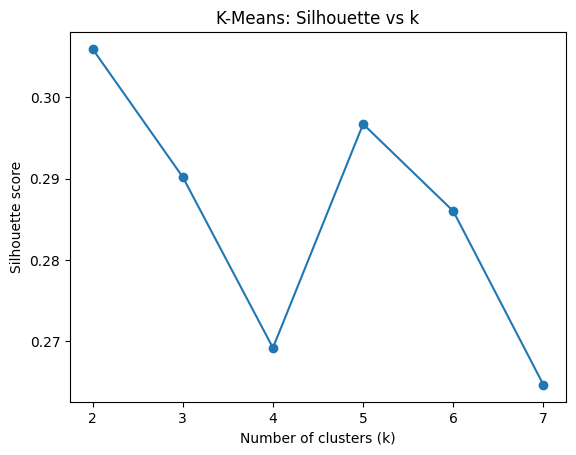

Best k = 2


In [ ]:
#KMeans
k_values = range(2, 8)
sil_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure()
plt.plot(list(k_values), sil_scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("K-Means: Silhouette vs k")
plt.show()

best_k = list(k_values)[int(np.argmax(sil_scores))]
print("Best k =", best_k)


In [ ]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df["cluster_kmeans"] = kmeans.fit_predict(X_scaled)

df[["city","country","cluster_kmeans"]].head(10)

,city,country,cluster_kmeans
0,Tokyo,Japan,1
1,New York,United States of America,1
2,Mexico City,Mexico,0
3,Mumbai,India,0
4,São Paulo,Brazil,0
5,Shanghai,China,1
6,Kolkata,India,0
7,Dhaka,Bangladesh,0
8,Buenos Aires,Argentina,1
9,Los Angeles,United States of America,1


In [ ]:
#Agglomerative clustering + DBScan
df["cluster_agg"] = AgglomerativeClustering(
    n_clusters=best_k, linkage="ward"
).fit_predict(X_scaled)

df["cluster_dbscan"] = DBSCAN(
    eps=1.2, min_samples=3
).fit_predict(X_scaled)

df["cluster_dbscan"].value_counts()

,count
cluster_dbscan,
-1,22
3,5
2,4
0,3
1,3
4,3


In [ ]:
#model comparison
def safe_silhouette(labels):
    return silhouette_score(X_scaled, labels) if len(set(labels)) > 1 else np.nan

def safe_db(labels):
    return davies_bouldin_score(X_scaled, labels) if len(set(labels)) > 1 else np.nan

comparison = pd.DataFrame([
    {
        "Model": "K-Means",
        "Clusters": len(set(df["cluster_kmeans"])),
        "Silhouette": safe_silhouette(df["cluster_kmeans"]),
        "Davies-Bouldin": safe_db(df["cluster_kmeans"])
    },
    {
        "Model": "Agglomerative",
        "Clusters": len(set(df["cluster_agg"])),
        "Silhouette": safe_silhouette(df["cluster_agg"]),
        "Davies-Bouldin": safe_db(df["cluster_agg"])
    },
    {
        "Model": "DBSCAN",
        "Clusters": len(set(df["cluster_dbscan"])),
        "Silhouette": safe_silhouette(df["cluster_dbscan"]),
        "Davies-Bouldin": safe_db(df["cluster_dbscan"])
    }
])

comparison

,Model,Clusters,Silhouette,Davies-Bouldin
0,K-Means,2,0.305945,1.227786
1,Agglomerative,2,0.300383,1.190113
2,DBSCAN,6,-0.023299,2.747958


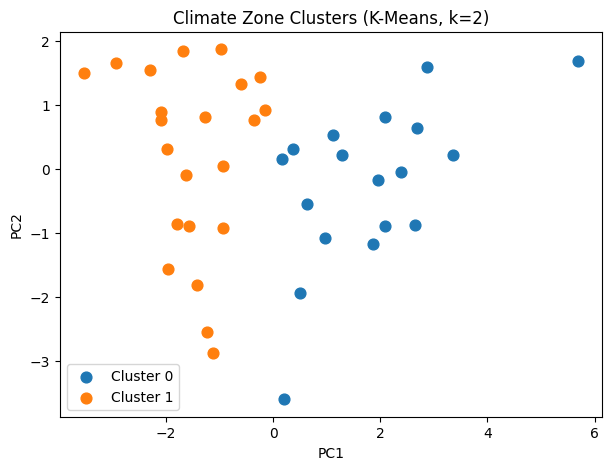

In [ ]:
#PCA visualization
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
for c in sorted(df["cluster_kmeans"].unique()):
    m = df["cluster_kmeans"] == c
    plt.scatter(Z[m,0], Z[m,1], s=60, label=f"Cluster {c}")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"Climate Zone Clusters (K-Means, k={best_k})")
plt.legend()
plt.show()

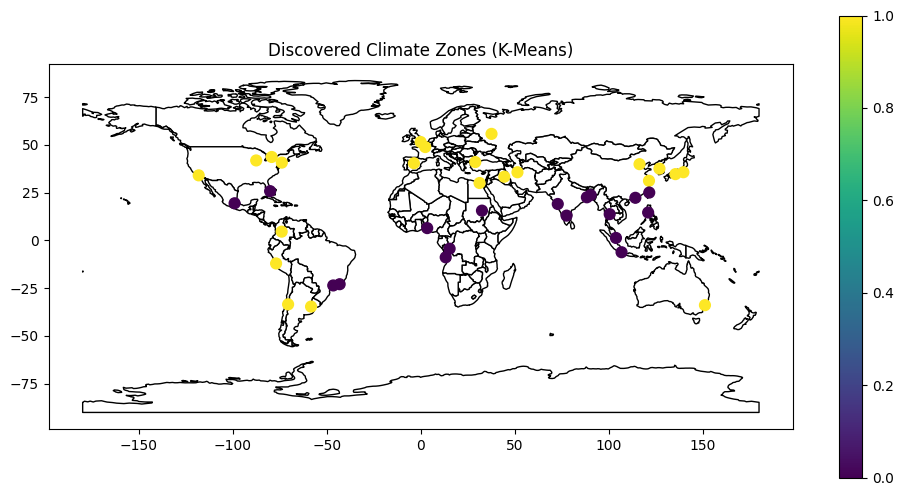

In [ ]:
#world map
WORLD_URL = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(WORLD_URL)

gdf_points = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["lon"], df["lat"]),
    crs="EPSG:4326"
)

ax = world.plot(figsize=(12,6), color="white", edgecolor="black")
gdf_points.plot(
    ax=ax,
    column="cluster_kmeans",
    legend=True,
    markersize=60
)
plt.title("Discovered Climate Zones (K-Means)")
plt.show()

In [ ]:
cluster_summary = df.groupby("cluster_kmeans")[feature_cols].mean().round(2)
cluster_summary

,t_mean,t_seasonality,t_warmest,t_coldest,prcp_total,prcp_seasonality,prcp_wettest,prcp_driest
cluster_kmeans,,,,,,,,
0,24.97,2.14,27.82,21.38,51.39,2.91,9.64,0.86
1,15.23,6.83,24.97,5.56,26.94,1.10,4.54,0.90


In [ ]:
df.to_csv("climate_zone_city_clusters.csv", index=False)
print("Saved climate_zone_city_clusters.csv")

Saved climate_zone_city_clusters.csv
